In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from geopy.distance import great_circle as GRC

In [18]:
df = pd.read_csv("data_problem_1.csv")
print(df.head())

# Converting timestamps to datetime datatype
df['order_pickedup_time'] = pd.to_datetime(df['order_pickedup_time'])
df['order_delivered_time'] = pd.to_datetime(df['order_delivered_time'])

# finding eta
df['ETA'] = (df['order_delivered_time'] - df['order_pickedup_time']).dt.total_seconds() / 60.0

# calculating distance
#df['distance'] = df.apply(lambda row: geodesic((row['R_Lat'], row['R_Lon']), (row['C_Lat'], row['C_Lat'])).km, axis=1)
df['distance'] = df.apply(lambda row: GRC((row['R_Lat'], row['R_Lon']), (row['C_Lat'], row['C_Lon'])).km, axis=1)

# spliting into multiple features
df['hour_of_day'] = df['order_pickedup_time'].dt.hour
df['day_of_week'] = df['order_pickedup_time'].dt.dayofweek

# outlier removal
df = df[df['ETA'] < df['ETA'].quantile(0.95)]  # Keep only the 95th percentile

# Removing 0 ETAs from the dataset
zero_eta_count = df[df['ETA'] == 0].shape[0]
print(f'Number of deliveries with zero ETA: {zero_eta_count}')
df = df[df['ETA'] != 0]


          order_id      R_Lon      R_Lat      C_Lon      C_Lat  \
0  PRD_ZMT_2960011  77.063728  28.468983  77.071230  28.449929   
1  PRD_ZMT_2964555  77.063728  28.468983  77.066637  28.454522   
2  PRD_ZMT_2968945  77.063728  28.468983  77.067590  28.461570   
3  PRD_ZMT_2976663  77.063728  28.468983  77.058401  28.455738   
4  PRD_ZMT_2985948  77.063728  28.468983  77.083967  28.440068   

   order_pickedup_time order_delivered_time  
0  2016-04-23 09:30:20  2016-04-23 09:57:04  
1  2016-04-23 11:05:32  2016-04-23 11:27:10  
2  2016-04-23 14:49:07  2016-04-23 15:07:18  
3  2016-04-23 16:43:14  2016-04-23 17:16:12  
4  2016-04-24 07:54:14  2016-04-24 08:16:29  
Number of deliveries with zero ETA: 7138


In [19]:
# Prepare the data
X = df[['distance', 'hour_of_day', 'day_of_week']]
y = df['ETA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#model creation using RandomizedSearchCV

param_dist = {
    # Randomly select between 50 and 150 trees
    'n_estimators': randint(50, 150),
    # Include None and depths from 5 to 15
    'max_depth': [None] + list(range(5, 15)),
    'min_samples_split': randint(2, 6),  # Randomly select between 2 and 5
}


random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Reduced number of iterations
    cv=3,  # Reduced number of cross-validation folds
    scoring='neg_mean_absolute_error',
    random_state=42
)


random_search.fit(X_train, y_train)




RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021359EF1F10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021358C723D0>},
                   random_state=42, scoring='neg_mean_absolute_error')

In [20]:

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluating model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')



Mean Absolute Error (MAE): 6.978002755165778
Mean Squared Error (MSE): 77.29869663939805
Root Mean Squared Error (RMSE): 8.791967734210473


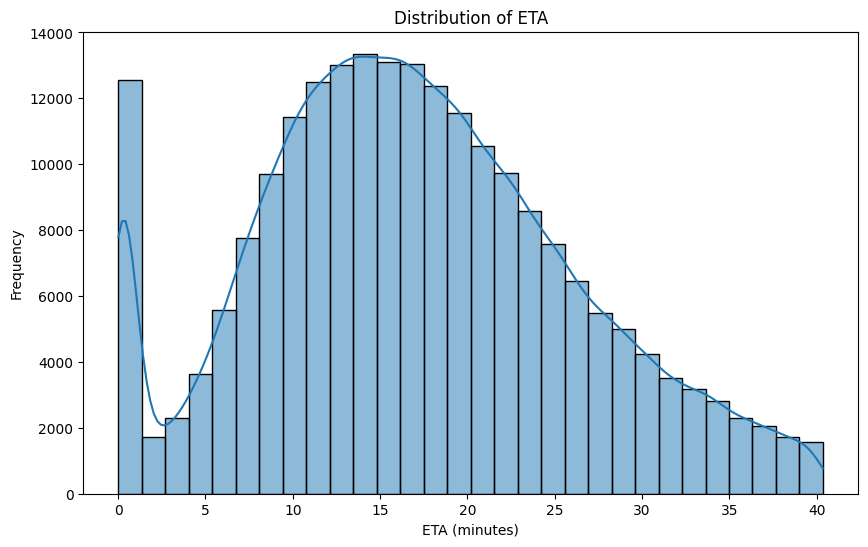

In [22]:
# Distribution of ETA
plt.figure(figsize=(10, 6))
sns.histplot(df['ETA'], bins=30, kde=True)
plt.title('Distribution of ETA')
plt.xlabel('ETA (minutes)')
plt.ylabel('Frequency')
plt.show()


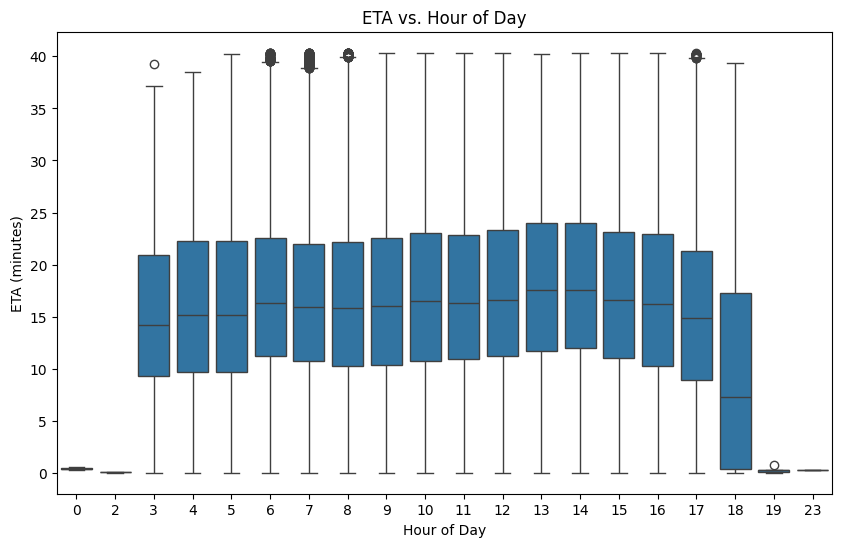

In [23]:

# ETA vs. Hour of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour_of_day', y='ETA', data=df)
plt.title('ETA vs. Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('ETA (minutes)')
plt.show()


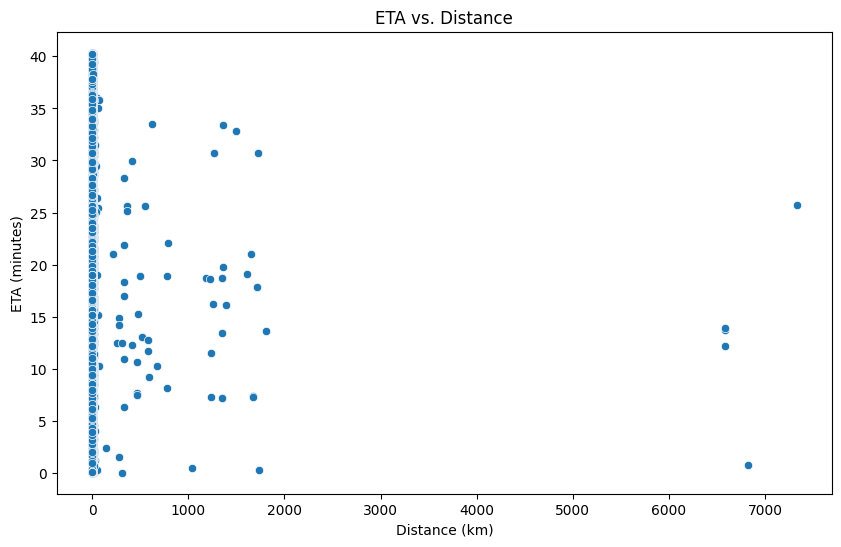

In [24]:

# ETA vs. Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance', y='ETA', data=df)
plt.title('ETA vs. Distance')
plt.xlabel('Distance (km)')
plt.ylabel('ETA (minutes)')
plt.show()


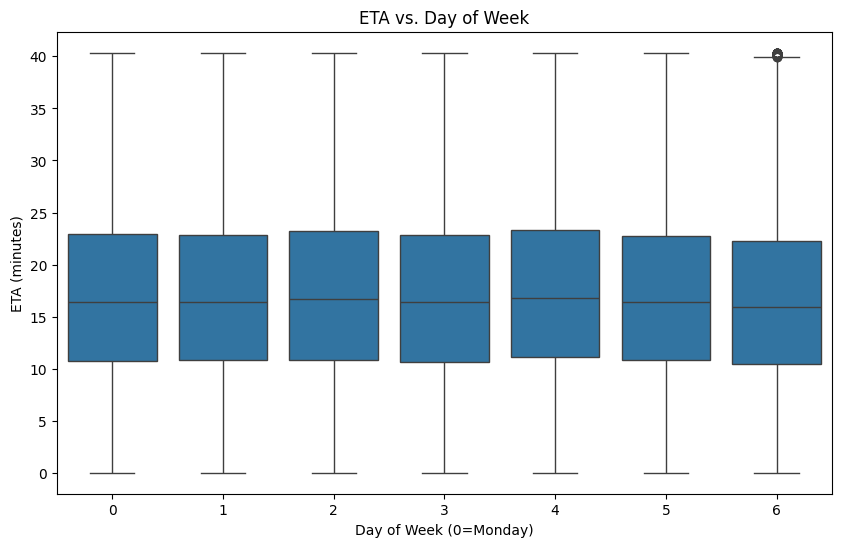

In [25]:
# ETA vs. Day of Week
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='ETA', data=df)
plt.title('ETA vs. Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('ETA (minutes)')
plt.show()

